<a id='intro'></a>
# Microsoft RL Open Source Fest Application - Data science exercise

<a id='problem_statement'></a>
## Problem Statement
Modifying [Context Personalization with Contextual Bandit](https://vowpalwabbit.org/tutorials/cb_simulation.html).
<ol>
<li> Add multiple changes to reward distribution over time
<li> Introducing Varying noise in the reward distribution
<li> Running new simulation with different exploration algorithms, visualize and compare the performance
</ol>

## Change in reward distribution

Multiple changes to reward over time:<br>
<b>*Tom*</b>

|           | get_cost | get_cost_new1 | get_cost_new2 | get_cost_new3 | get_cost_new4 | get_cost_new5 |
|-----------|----------|---------------|---------------|---------------|---------------|---------------|
| Morning   | Politics | Politics      | Finance       | Health        | Health        | Politics      |
| Afternoon | Music    | Sports        | Sports        | Finance       | Food          | Camping       |

<b>*Anna*</b>

|           | get_cost | get_cost_new1 | get_cost_new2 | get_cost_new3 | get_cost_new4 | get_cost_new5 |
|-----------|----------|---------------|---------------|---------------|---------------|---------------|
| Morning   | Sports   | Sports        | Food          | Health        | Food          | Camping       |
| Afternoon | Politics | Sports        | Camping       | Finance       | Finance       | Sports        |


## Varying noise in the reward distribution

Adding noise in the distribution implies that the user may or maynot "click" the preferred articles. This is simulated by adding a probability of clicking (click_probability) the preferred article by the user. For the purpose of simulation this value is set to 0.8, impling that the user will click on the preferred article 80% of the times. Other times he/she may not like to read the article or would want other article to be shown.<br><br>

The cost function modification and change of distribution over time can be found in the section [changes in reward distribution](#reward_distribution_change)

## Results
Comparison of the best performing parameters for each of the exploration algorithm can be found in the section [Exploration Algorithm Comparison](#comparing_algos).<br>
Experiments for different algorithms to select the best parameters can be found in the sections:

1. [Explore First](#explore_first)
2. [$\epsilon$-Greedy](#e-greedy)
3. [Bagging Explorer](#bagging)
4. [Online Cover](#online_cover)
5. [Softmax Explorer](#softmax_explorer)

<!-- 
<ol>
    <li> [Explore First](#explore_first)
    <li> [$\epsilon$-Greedy](#e-greedy)
    <li> [Bagging Explorer](#bagging)
    <li> [Online Cover](#online_cover)
    <li> [Softmax Explorer](#softmax_explorer)
</ol> -->

In [1]:
from vowpalwabbit import pyvw
import random
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [20, 5]

In [2]:
USER_LIKED_ARTICLE = -1.0
USER_DISLIKED_ARTICLE = 0.0
NUM_ITERATIONS = 3000
click_probability = 0.8
SEED = 5

In [3]:
# This function modifies (context, action, cost, probability) to VW friendly format
def to_vw_example_format(context, actions, cb_label = None):
    if cb_label is not None:
        chosen_action, cost, prob = cb_label
    example_string = ""
    example_string += "shared |User user={} time_of_day={}\n".format(context["user"], context["time_of_day"])
    for action in actions:
        if cb_label is not None and action == chosen_action:
            example_string += "0:{}:{} ".format(cost, prob)
        example_string += "|Action article={} \n".format(action)
    #Strip the last newline
    return example_string[:-1]

# Testing
context = {"user":"Tom","time_of_day":"morning"}
actions = ["politics", "sports", "music", "food"]

print(to_vw_example_format(context,actions))

shared |User user=Tom time_of_day=morning
|Action article=politics 
|Action article=sports 
|Action article=music 
|Action article=food 


In [4]:
def sample_custom_pmf(pmf):
    total = sum(pmf)
    scale = 1 / total
    pmf = [x * scale for x in pmf]
    draw = random.random()
    sum_prob = 0.0
    for index, prob in enumerate(pmf):
        sum_prob += prob
        if(sum_prob > draw):
            return index, prob

def get_action(vw, context, actions):
    vw_text_example = to_vw_example_format(context,actions)
    pmf = vw.predict(vw_text_example)
    chosen_action_index, prob = sample_custom_pmf(pmf)
    return actions[chosen_action_index], prob

In [5]:
users = ['Tom', 'Anna']
times_of_day = ['morning', 'afternoon']
actions = ["politics", "sports", "music", "food", "finance", "health", "camping"]

def choose_user(users):
    return random.choice(users)

def choose_time_of_day(times_of_day):
    return random.choice(times_of_day)

def plot_ctr(num_iterations, ctr, samples_per_preference):
    plt.plot(range(1,num_iterations+1), ctr)
    plt.xlabel('num_iterations', fontsize=14)
    plt.ylabel('ctr', fontsize=14)
    plt.ylim([0,1])
    i = samples_per_preference
    while i<len(ctr):
        plt.axvline(x=i, color="r", label="Preference change")
        i+=samples_per_preference
    plt.show()

<a id='reward_distribution_change'></a>
### Changes in reward distribution

<!-- # Second Scenario Modified

Multiple changes to reward over time:<br>
**TOM**

|           | get_cost | get_cost_new1 | get_cost_new2 | get_cost_new3 | get_cost_new4 | get_cost_new5 |
|-----------|----------|---------------|---------------|---------------|---------------|---------------|
| Morning   | Politics | Politics      | Finance       | Health        | Health        | Politics      |
| Afternoon | Music    | Sports        | Sports        | Finance       | Food          | Camping       |

**Anna**

|           | get_cost | get_cost_new1 | get_cost_new2 | get_cost_new3 | get_cost_new4 | get_cost_new5 |
|-----------|----------|---------------|---------------|---------------|---------------|---------------|
| Morning   | Sports   | Sports        | Food          | Health        | Food          | Camping       |
| Afternoon | Politics | Sports        | Camping       | Finance       | Finance       | Sports        |

The above table shows the news articles preferred by the user at different time of day. The different cost functions correspond to change of user preference over time. As these preferences are the most preferred ones, user may or maynot click on the article presented to him. Let's say that he clicks with a probability of $0.8$ i.e. for presented to him of Politics (at the start of episode) he clicks on the presented article for 8 out of 10 times. Other 2 times he may be not be interested in going through the complete article.<br> -->

In [6]:
preference1 = {
    "Tom": {
        "morning": "Politics",
        "afternoon": "Music"
    },
    "Anna": {
        "morning": "Sports",
        "afternoon": "Politics"
    }
}

preference2 = {
    "Tom": {
        "morning": "Politics",
        "afternoon": "Music"
    },
    "Anna": {
        "morning": "Sports",
        "afternoon": "Politics"
    }
}

preference3 = {
    "Tom": {
        "morning": "Finance",
        "afternoon": "Sport"
    },
    "Anna": {
        "morning": "Food",
        "afternoon": "Camping"
    }
}

preference4 = {
    "Tom": {
        "morning": "Health",
        "afternoon": "Finance"
    },
    "Anna": {
        "morning": "Health",
        "afternoon": "Finance"
    }
}

preference5 = {
    "Tom": {
        "morning": "Health",
        "afternoon": "Food"
    },
    "Anna": {
        "morning": "Food",
        "afternoon": "Finance"
    }
}

preference6 = {
    "Tom": {
        "morning": "Politics",
        "afternoon": "Camping"
    },
    "Anna": {
        "morning": "Camping",
        "afternoon": "Sports"
    }
}

def get_cost_modified(context, action, preference):
    time_of_day = context["time_of_day"]
    user = context["user"]
    if action.lower()==preference[user][time_of_day].lower():
        draw = random.random()
        if draw<=click_probability:
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
    else:
        return USER_DISLIKED_ARTICLE

In [7]:
def run_simulation_multiple_cost_functions(vw, num_iterations, users, times_of_day, actions, preferences, do_learn = True):
    cost_sum = 0.
    ctr = []

    start_counter = 1
    end_counter = start_counter + num_iterations
    for preference in preferences:
        for i in range(start_counter, end_counter):
            # 1. in each simulation choose a user
            user = choose_user(users)
            # 2. choose time of day for a given user
            time_of_day = choose_time_of_day(times_of_day)

            # Construct context based on chosen user and time of day
            context = {'user': user, 'time_of_day': time_of_day}

            # 3. Use the get_action function we defined earlier
            action, prob = get_action(vw, context, actions)

            # 4. Get cost of the action we chose
            cost = get_cost_modified(context, action, preference)
            cost_sum += cost

            if do_learn:
                # 5. Inform VW of what happened so we can learn from it
                vw_format = vw.parse(to_vw_example_format(context, actions, (action, cost, prob)),pyvw.vw.lContextualBandit)
                # 6. Learn
                vw.learn(vw_format)

            # We negate this so that on the plot instead of minimizing cost, we are maximizing reward
            ctr.append(-1*cost_sum/i)
        start_counter = end_counter
        end_counter = start_counter + num_iterations

    return ctr

In [8]:
def get_data(experiments, preferences):
    results = {}
    random.seed(SEED)
    for params, label in experiments:
        vw = pyvw.vw(f"--cb_explore_adf -q UA --quiet {params}")
        ctr_learn = run_simulation_multiple_cost_functions(vw, NUM_ITERATIONS, users, times_of_day, actions, preferences)
        ctr_no_learn = run_simulation_multiple_cost_functions(vw, NUM_ITERATIONS, users, times_of_day, actions, preferences, do_learn=False)
        results[label] = [ctr_learn, ctr_no_learn]
    return results
# plot_ctr(total_iterations, ctr, NUM_ITERATIONS)

def plot_ctr(results):
    fig, ax = plt.subplots(1,2)
    for label, [learn_data, no_learn_data] in results.items():
#         plt.subplot(121)
        ax[0].plot(learn_data, label=label)
#         plt.subplot(122)
        ax[1].plot(no_learn_data, label=label)
    i = NUM_ITERATIONS
    while i<len(learn_data):
        ax[0].axvline(x=i, color="r")
        ax[1].axvline(x=i, color="r")
        i+=NUM_ITERATIONS
#     plt.subplot(121)
    ax[0].title.set_text("Learning enabled")
    ax[0].legend(loc="best")
    ax[0].set_ylim([0,1])
#     plt.subplot(122)
    ax[1].legend(loc="best")
    ax[1].title.set_text("Learning disabled")
    ax[1].set_ylim([0,1])
    plt.show()

<a id='comparing_algos'></a>
# Exploration Algorithm Comparison
Here I have compared 
<ul>
        <li> Explore-First ($\tau = 100$)
        <li> $\epsilon$-greedy (0.05)
        <li> Bagging Explorer ($m = 10$)
        <li> Online Cover (50)
        <li> Softmax Explorer ($\lambda = 10$)
        <li> RND Explorer (5, $\epsilon = 6.25 \times 10^{-3}$)
</ul>
<br>
The verticle red lines in the plots shows the time when there is a preference change.<br>
It can be noted that RND Explorer and Softmax Explorer have the best consistent performance compared to others as the preferences change. Explore first is not able to capture the change of preference, while epsilon greedy is not that effective in learning. The bagging explorer and online cover have not been able to learn the preferences fairly nicely and have adapted to changing preferences well.

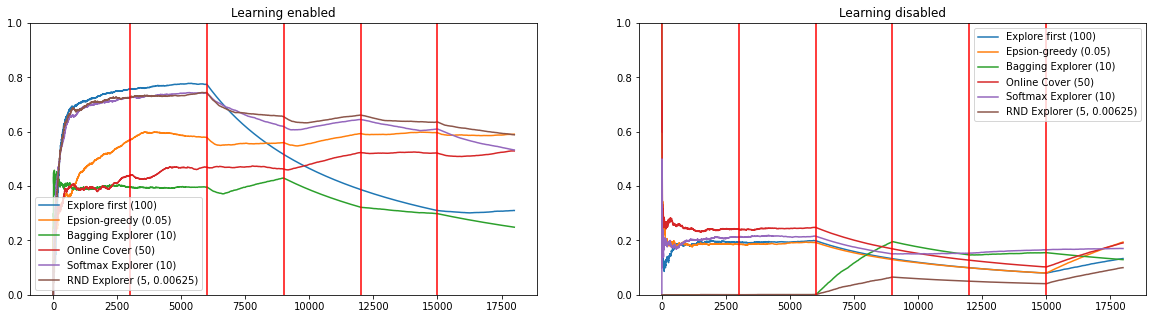

In [9]:
preferences = [preference1, preference2, preference3, preference4, preference5, preference6]

exploration_algo = [
    ["--first 100", "Explore first (100)"],
    ["--epsilon 0.05", "Epsion-greedy (0.05)"],
    ["--bag 10", "Bagging Explorer (10)"],
    ["--cover 50", "Online Cover (50)"],
    ["--softmax --lambda 10", "Softmax Explorer (10)"],
    ["--rnd 5 --epsilon 0.00625", "RND Explorer (5, 0.00625)"]
]

data = get_data(exploration_algo, preferences)
plot_ctr(data)

<a id='explore_first'></a>
# Explore-First

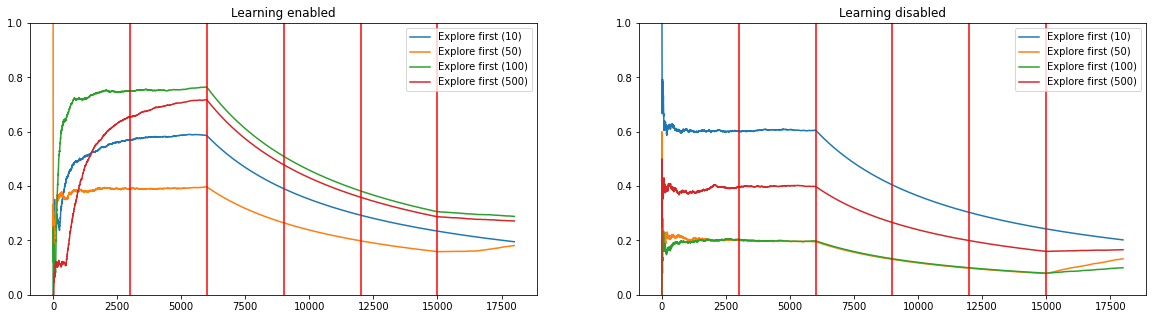

In [10]:
exploration_algo = [
    ["--first 10", "Explore first (10)"],
    ["--first 50", "Explore first (50)"],
    ["--first 100", "Explore first (100)"],
    ["--first 500", "Explore first (500)"],
]

data = get_data(exploration_algo, preferences)
plot_ctr(data)

<a id='e-greedy'></a>
# $\epsilon$ Greedy

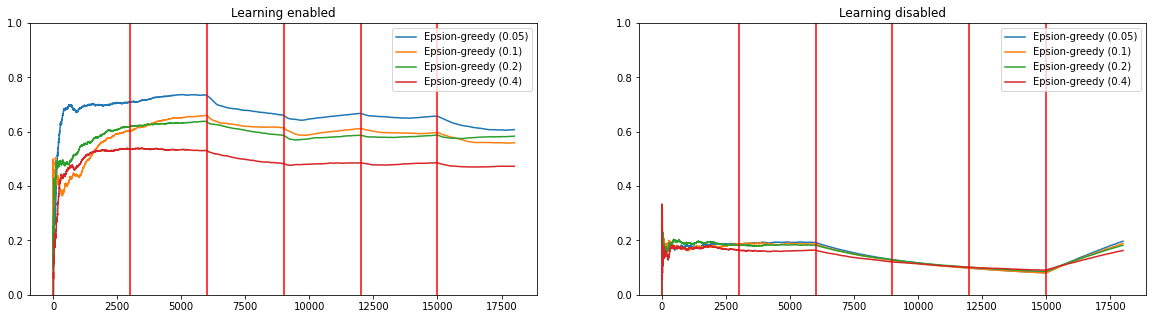

In [11]:
exploration_algo = [
    ["--epsilon 0.05", "Epsion-greedy (0.05)"],
    ["--epsilon 0.1", "Epsion-greedy (0.1)"],
    ["--epsilon 0.2", "Epsion-greedy (0.2)"],
    ["--epsilon 0.4", "Epsion-greedy (0.4)"],
]

data = get_data(exploration_algo, preferences)
plot_ctr(data)

<a id='bagging'></a>
# Bagging Explorer

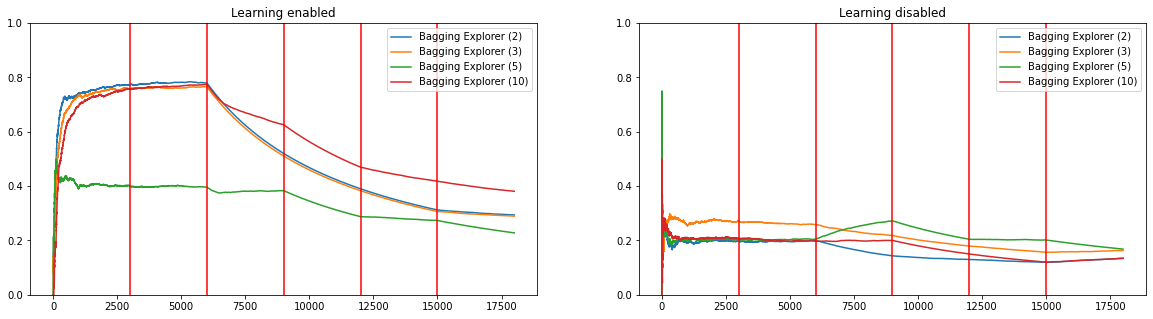

In [12]:
exploration_algo = [
    ["--bag 2", "Bagging Explorer (2)"],
    ["--bag 3", "Bagging Explorer (3)"],
    ["--bag 5", "Bagging Explorer (5)"],
    ["--bag 10", "Bagging Explorer (10)"]
]

data = get_data(exploration_algo, preferences)
plot_ctr(data)

<a id='online_cover'></a>
# Online Cover

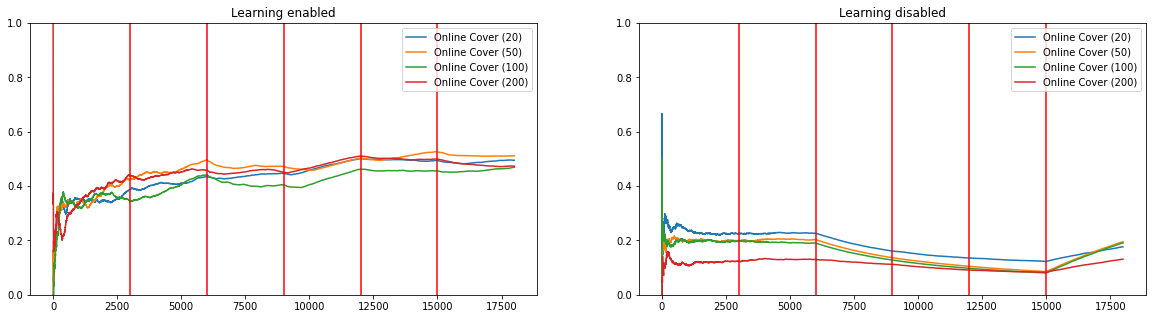

In [13]:
exploration_algo = [
    ["--cover 20", "Online Cover (20)"],
    ["--cover 50", "Online Cover (50)"],
    ["--cover 100", "Online Cover (100)"],
    ["--cover 200", "Online Cover (200)"],
]

data = get_data(exploration_algo, preferences)
plot_ctr(data)

<a id='softmax_explorer'></a>
# Softmax Explorer

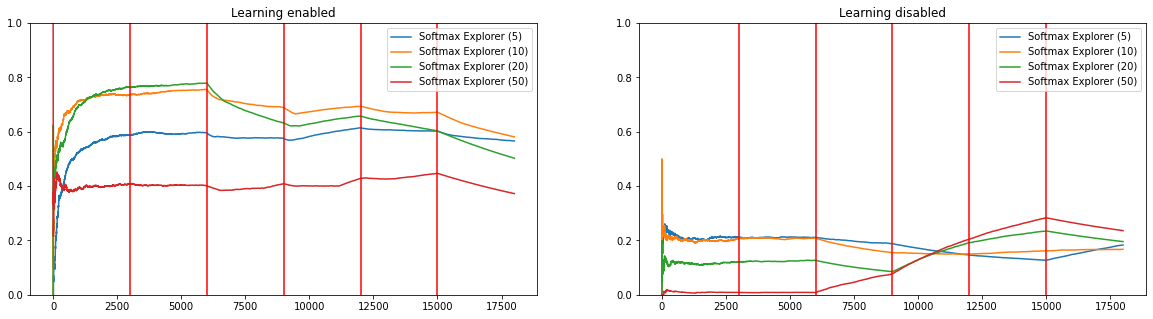

In [14]:
exploration_algo = [
    ["--softmax --lambda 5", "Softmax Explorer (5)"],
    ["--softmax --lambda 10", "Softmax Explorer (10)"],
    ["--softmax --lambda 20", "Softmax Explorer (20)"],
    ["--softmax --lambda 50", "Softmax Explorer (50)"]
]

data = get_data(exploration_algo, preferences)
plot_ctr(data)

<a id='softmax_explorer'></a>
# RND Explorer

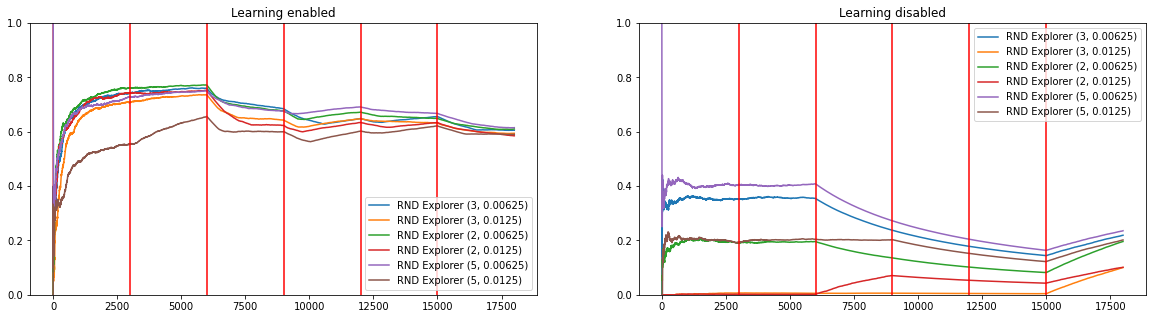

In [15]:
exploration_algo = [
    ["--rnd 3 --epsilon 0.00625", "RND Explorer (3, 0.00625)"],
    ["--rnd 3 --epsilon 0.0125", "RND Explorer (3, 0.0125)"],
#     ["--rnd 3 --epsilon 0.025", "RND Explorer (3, 0.025)"],
#     ["--rnd 3 --epsilon 0.05", "RND Explorer (3, 0.05)"],
    
    ["--rnd 2 --epsilon 0.00625", "RND Explorer (2, 0.00625)"],
    ["--rnd 2 --epsilon 0.0125", "RND Explorer (2, 0.0125)"],
#     ["--rnd 2 --epsilon 0.025", "RND Explorer (2, 0.025)"],
#     ["--rnd 2 --epsilon 0.05", "RND Explorer (2, 0.05)"],
    
    ["--rnd 5 --epsilon 0.00625", "RND Explorer (5, 0.00625)"],
    ["--rnd 5 --epsilon 0.0125", "RND Explorer (5, 0.0125)"],
#     ["--rnd 5 --epsilon 0.025", "RND Explorer (5, 0.025)"],
#     ["--rnd 5 --epsilon 0.05", "RND Explorer (5, 0.05)"]
]

data = get_data(exploration_algo, preferences)
plot_ctr(data)

# Acknowledgement
I would like to thank Microsoft Research's RL Open Source team and Vowpal wabbit for providing me possible oppurtunity to contribute to Vowpal Wabbit's open source developement for summer of 2021 and help me develop my interests in Reinforcement learning while making contribution to open source.